# PPO Algorithm

### Imports

In [77]:
#!pip install gymnasium stable-baselines3[extra] moviepy
#!pip install sb3-contrib

In [78]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import pathlib
from sb3_contrib import RecurrentPPO
from IPython.display import clear_output, display, HTML
import imageio.v2 as imageio

### Costum Callback

In [79]:
# Costum Callback class for saving rewards and episode lengths
class EpisodeLoggerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.episode_lengths = []

    # Access the environment's info for the current step
    def _on_step(self) -> bool:
        if "episode" in self.locals["infos"][0]:
            episode_info = self.locals["infos"][0]["episode"]
            self.episode_rewards.append(episode_info["r"])
            self.episode_lengths.append(episode_info["l"])
        return True

Here I create a custom callback class. I use it to log the whole training episode metrics (rewards and lengths) and not only for the last 100 that is set as default. I use this for monitoring and analysis of training progress by collecting performance metrics during the agent's interaction with the environment.

## Model Training and Analysis

Here I initialise the PPO algorithm with the Stable-Baselines3 default hyperparameters, and I use the "MlpPolicy" that utilises 2 MLP forward networks, one to parametrise policy updates and one for the value updates.

In the Stable-Baselines3 implementation of the PPO algorithm with the MlpPolicy, two multi-layer perceptron neural networks are utilised:

### Policy Network (Actor):

$
\pi_\theta(a|s) = \mathcal{N}(\mu_\theta(s), \sigma_\theta(s)^2)
$

This one determines the actions the agent should take based on the current state and updates the policy. (Continuous Action Space)

### Value Network (Critic):

$V_\phi(s) = f_\phi(s)$

This one calculates the value function $V_\phi(s)$, the expected cumulative reward from a given state. Helps to calculate the advantage function $A_t$, which evaluates how good an action is compared to the expected value.

### Generalized Advantage Estimation (GAE)

$
\hat{A}_t = \delta_t + (\gamma \lambda) \delta_{t+1} + (\gamma \lambda)^2 \delta_{t+2} + \cdots + (\gamma \lambda)^{T-t+1} \delta_{T-1},
$

$
\text{where } \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t).
$

With GAE, the algorithm computes the advantage function $A_t$ by weighting temporal difference (TD) errors across multiple future steps. GAE helps the algorithm to stabilise the training and be more efficient.


Both MLPs have the default structure:

- **2 hidden layers** with **64 neurones** each.
- **Tanh** Activation function for hidden layers.
- **Adam** optimiser.

### Total Time Steps Analysis

Here I will test how the agent trains and interacts with the environment for 2 different timestep values: 40k and 100k.

In [80]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
timesteps = [40_000, 100_000]
all_rewards = []
trial_rew_mean = []


for timestep in timesteps:

  #Training trials with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {timestep} timesteps")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=3e-4,                                             # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=0.0,                                                   # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=False,                                                  # Use generalized State Dependent Exploration (gSDE)
      seed=42,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=timestep, callback=logger_callback)

  # Store the rewards from this session
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with 40000 timesteps
All episodes: 41

Training with 100000 timesteps
All episodes: 100
Model PPO_MLP saved successfully.


#### Total Rewards Plot

<Figure size 1000x600 with 0 Axes>

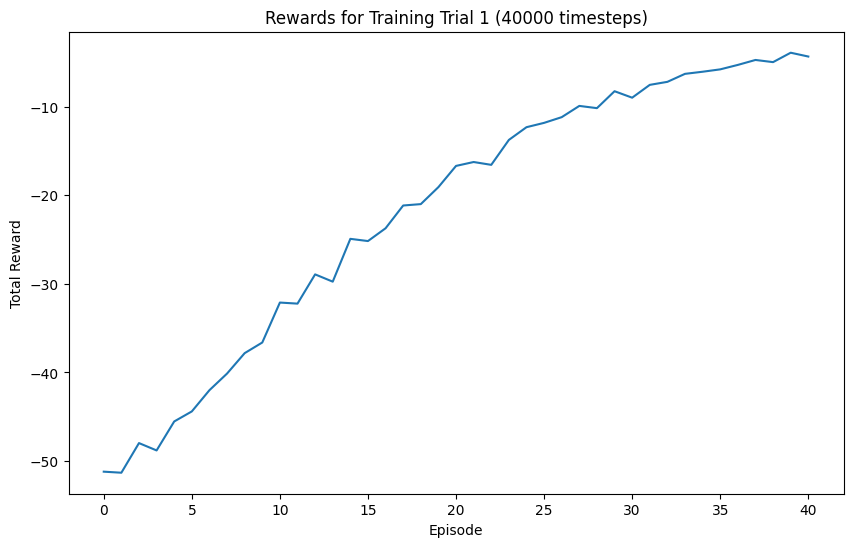

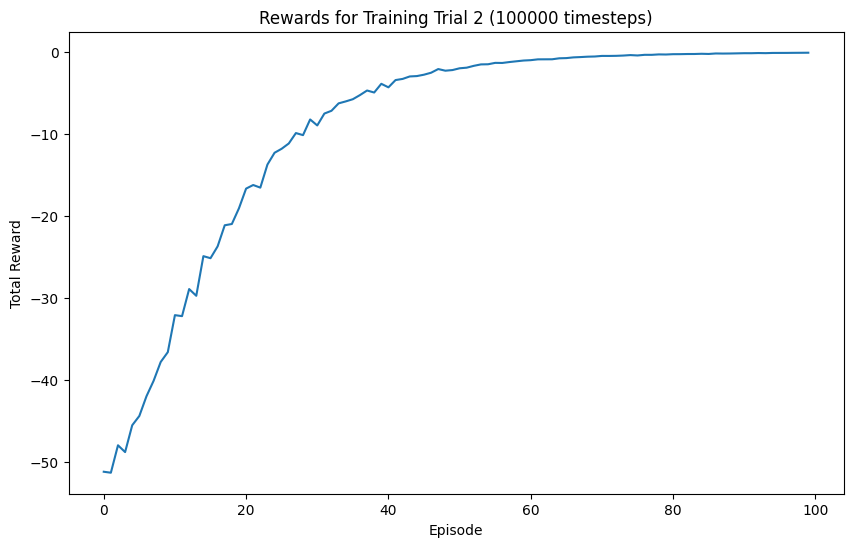

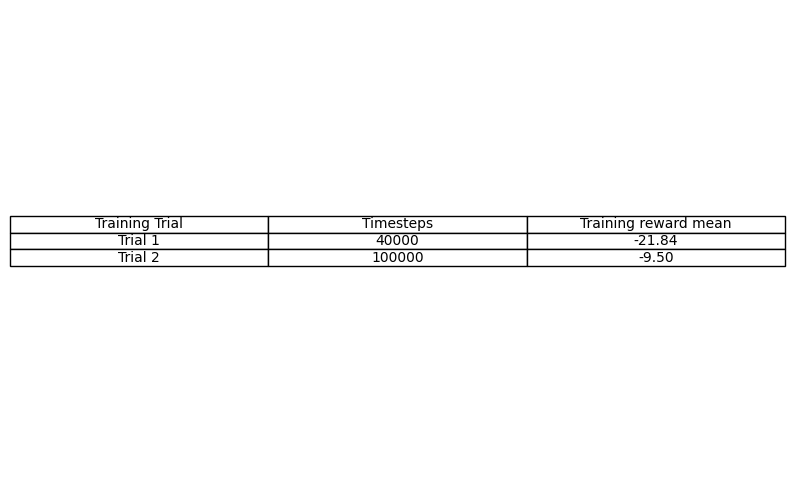

In [81]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({timesteps[i]} timesteps)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", timesteps[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Timesteps", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
These graphs represent the total rewards per episode over the training period. The x-axis shows the episode number, and the y-axis shows the cumulative reward for each episode. At first glance we see that the algorithm is improving, as the rewards increase from -50 toward 0. However, for both 40k and 100k total timesteps, the rewards stabilise around 0 and do not exceed this value, showing that the agent has plateaued and is not learning the optimal policy. That happens because it tries to maximise the reward only with small moves back and forth, making it stuck at 0, never reaching the goal of +100 reward. This possibly happens because the agent doesn't explore enough.

C:\Users\wowac\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(



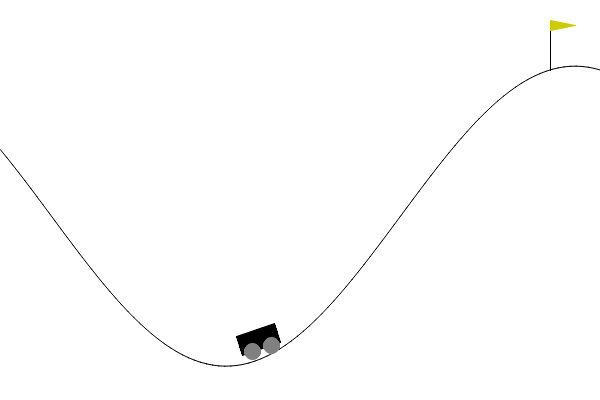

In [82]:
# Load the trained model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
model = PPO.load("PPO_MLP")
frames = []

# Test the model and save frames
obs, info = env.reset()
terminated, truncated = False, False

while not (terminated or truncated):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    frame = env.render()
    frames.append(frame)

env.close()

# Save the frames as a GIF
gif_filename = "mountain_car_simulation.gif"
imageio.mimsave(gif_filename, frames, fps=30, loop=0)

# Display the GIF
with open(gif_filename, 'rb') as f:
    data = f.read()
    b64_data = base64.b64encode(data).decode('utf-8')
    display(HTML(f'<img src="data:image/gif;base64,{b64_data}" width="600">'))


### State-Dependent Exploration Analysis

The SDE parameter controls whether the state-dependent exploration mechanism is used during training.

When set to False, the default exploration strategy is used (independent Gaussian noise). Computationally cheaper and sufficient for standard tasks.

When set to True, SDE replaces the standard noise in the policy with state-dependent noise, allowing for more structured and adaptive exploration based on the state, better for continuous action space but computationally expensive. The noise is sampled once in the start of a rollout. For testing this hyperparameter, I will use 100k total timesteps.

- $
\pi_\theta(a \mid s) = \mathcal{N}(\mu_\theta(s), \sigma_s^2)
$: The action $a$ is sampled from a Gaussian distribution with mean $\mu_\theta(s)$ and state-dependent variance $\sigma_s^2$.


- $
a_t = \mu(s_t, \theta_\mu) + \epsilon(s_t, \theta_\epsilon)
$: The action $a_t$ is the sum of the deterministic policy and the state-dependent noise.

- $
\epsilon(s_t, \theta_\epsilon) = \theta_\epsilon \cdot s_t
$: The state-dependent noise is a linear transformation of the state $s_t$.

- $
\theta_\epsilon \sim \mathcal{N}(0, \sigma^2)
$


In [83]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
sdes = [False, True]
all_rewards = []
trial_rew_mean = []


for sde in sdes:

  # Training trials with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with SDE {sde}")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=3e-4,                                             # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=0.0,                                                   # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=sde,                                                    # Use generalized State Dependent Exploration (gSDE)
      seed=42,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this trial
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with SDE False
All episodes: 100

Training with SDE True
All episodes: 289
Model PPO_MLP saved successfully.


#### Total Rewards Plot

<Figure size 1000x600 with 0 Axes>

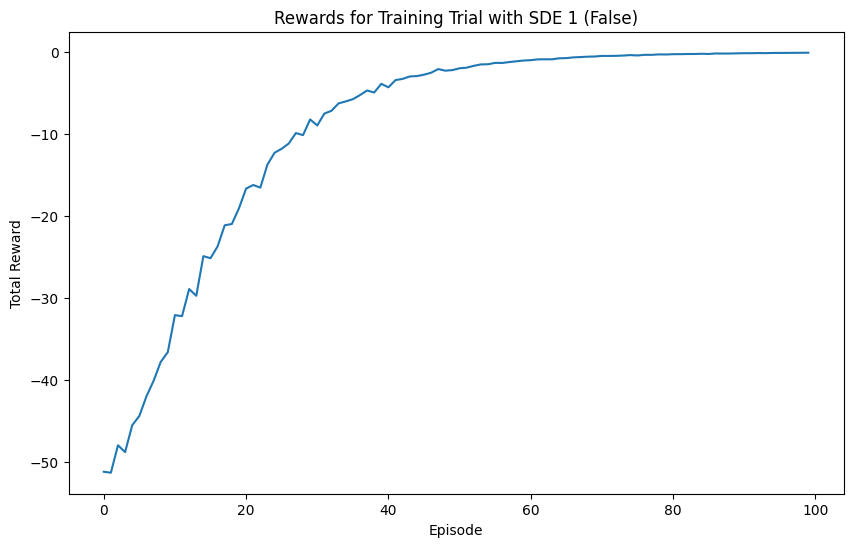

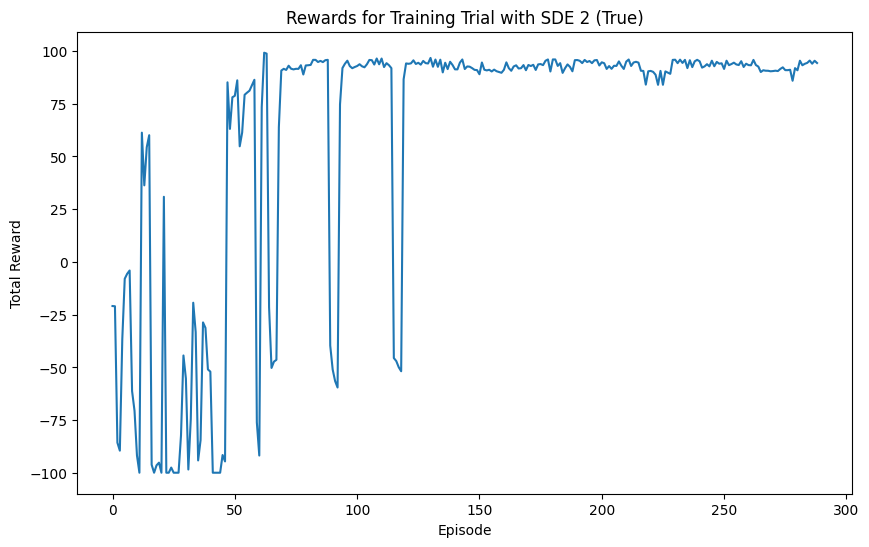

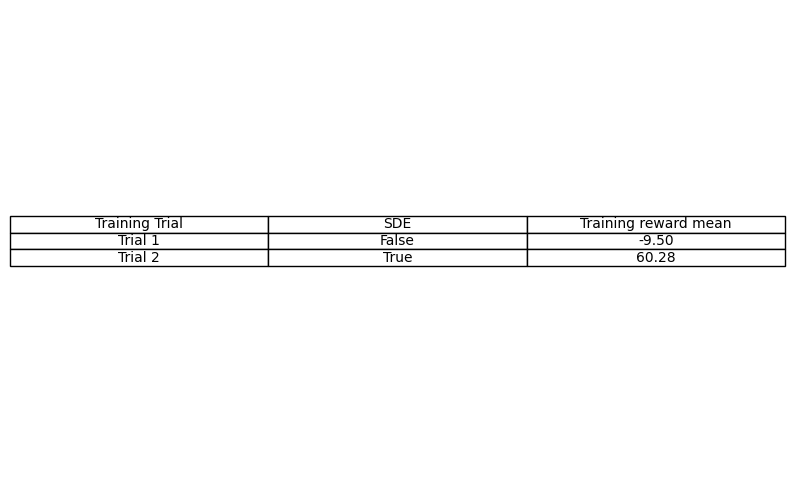

In [84]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial with SDE {i+1} ({sdes[i]})")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", sdes[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "SDE", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
In the first plot without the SDE mechanism, the training is stable, but the agent won't explore enough, as we saw in earlier experiments, so the agent fails to learn the optimal policy and stabilises near 0. In the second graph with SDE, the agent seems to explore the environment better and improve in general. After episode 125, the algorithm seems to converge with a training reward mean at 60.28.

### Entropy Coefficient Analysis

The (entropy coefficient) c2 controls the weight of the entropy term in the PPO loss function. Entropy measures the randomness in the agent's action distribution. Adding an entropy bonus will make the agent explore more by preventing the policy from becoming too deterministic early in training. For testing this hyperparameter, I will use 100k total timesteps.

**Full Objective Function:**

$
L^{\text{CLIP+VF+S}}_t(\theta) = \widehat{\mathbb{E}}_t \left[ L^{\text{CLIP}}_t(\theta) - c_1 L^{\text{VF}}_t(\theta) + c_2 S[\pi_\theta](s_t) \right]
$

- $
L^{\text{CLIP}}(\theta) = \widehat{\mathbb{E}}_t \left[ \min \left( r_t(\theta) \widehat{A}_t, \text{clip}\left(r_t(\theta), 1-\epsilon, 1+\epsilon \right) \widehat{A}_t \right) \right]
$

- $
L^{\text{VF}}_t(\theta) = \left( V_\theta(s_t) - V^{\text{target}}_t \right)^2
$

- $
S[\pi_\theta](s_t) = \frac{1}{2} \log(2\pi e \sigma^2)
$



In [85]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
ent_coefs = [1e-3, 1e-2, 1e-1]
all_rewards = []
trial_rew_mean = []


for ent_coef in ent_coefs:

  # Training trial with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {ent_coef} Entropy coefficient")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=3e-4,                                             # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=ent_coef,                                              # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=42,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this trial
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with 0.001 Entropy coefficient
All episodes: 129

Training with 0.01 Entropy coefficient
All episodes: 149

Training with 0.1 Entropy coefficient
All episodes: 219
Model PPO_MLP saved successfully.


#### Total Rewards Plot

<Figure size 1000x600 with 0 Axes>

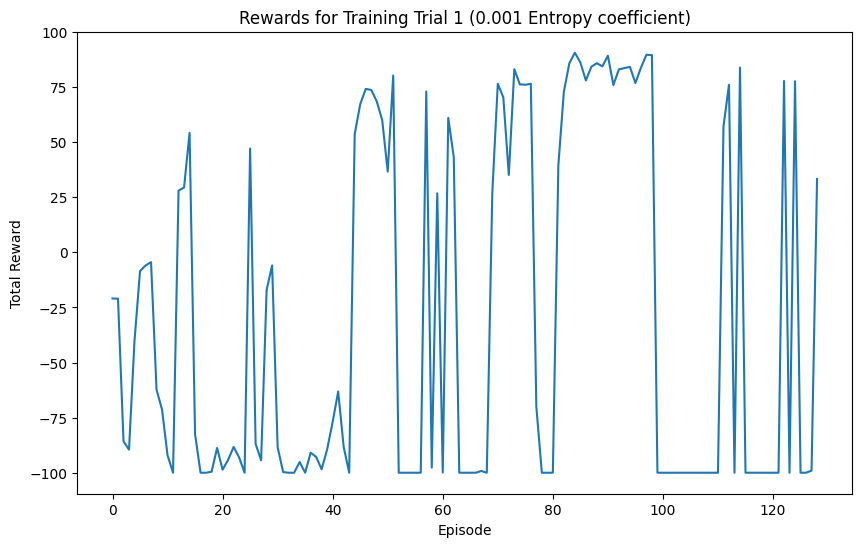

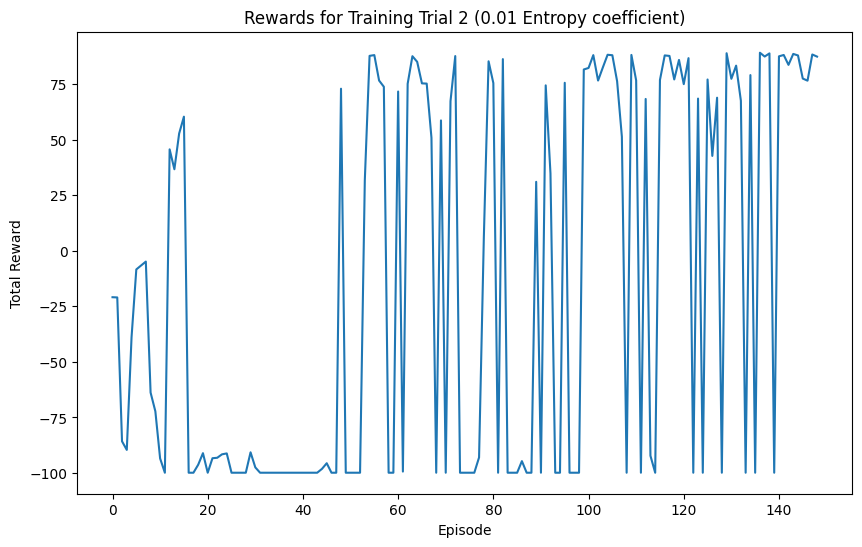

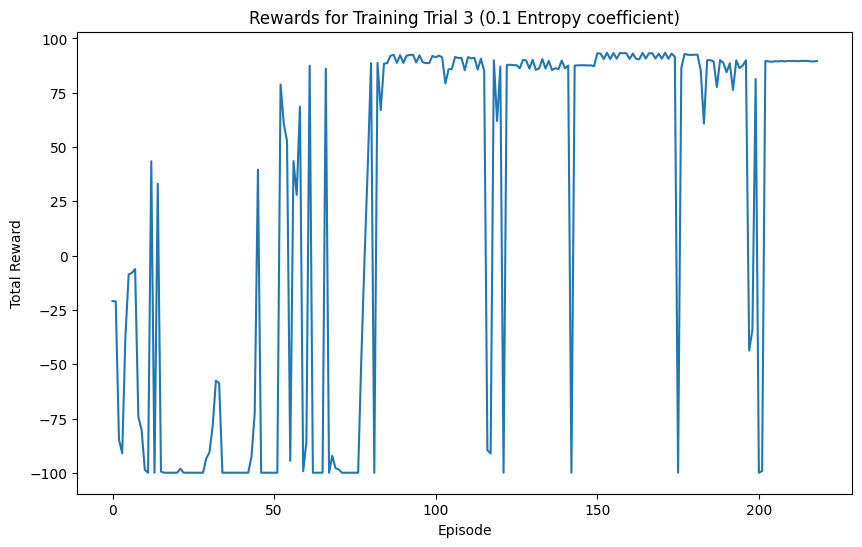

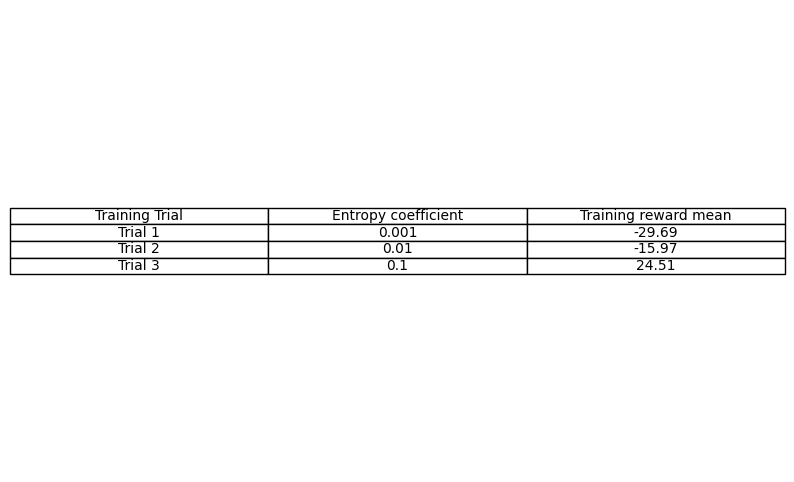

In [86]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({ent_coefs[i]} Entropy coefficient)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", ent_coefs[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Entropy coefficient", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
These graphs show the training process with different entropy coefficients. For a low entropy coefficient of 0.001, the agent struggles to explore effectively and fluctuates a lot, leading to less consistent improvement, and it's not converging. As the entropy coefficient increases by 0.01, the agent explores the environment more, having more high rewards with a lot of fluctuation. For a high entropy coefficient of 0.1, the agent continues to favour exploration and cannot find an optimal policy. This shows that while exploration increases, stability gets reduced.

### Learning Rate Analysis

The learning rate is a hyperparameter that controls the step size of the gradient updates for both the policy and value networks, which share the same optimizer. By default, PPO uses the Adam optimizer with a learning rate of 3e-4, which balances convergence speed and stability for most tasks. For testing this hyperparameter, I will use 100k total timesteps.

In [87]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
ln_rates = [3e-5, 3e-4, 3e-3]
all_rewards = []
trial_rew_mean = []


for ln_rate in ln_rates:

  # Training trial with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {ln_rate} Learning Rate")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=ln_rate,                                          # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=0.01,                                                  # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=42,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this trial
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with 3e-05 Learning Rate
All episodes: 111

Training with 0.0003 Learning Rate
All episodes: 149

Training with 0.003 Learning Rate
All episodes: 682
Model PPO_MLP saved successfully.


#### Total Rewards Plot

<Figure size 1000x600 with 0 Axes>

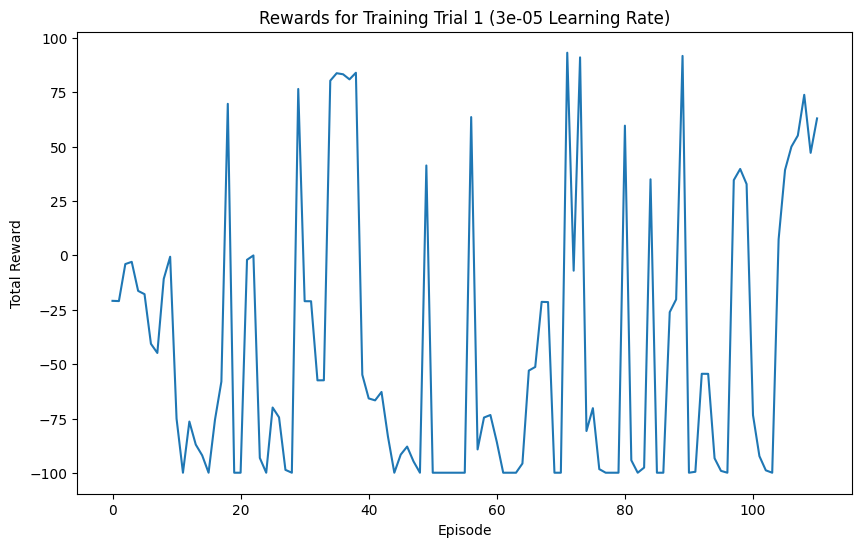

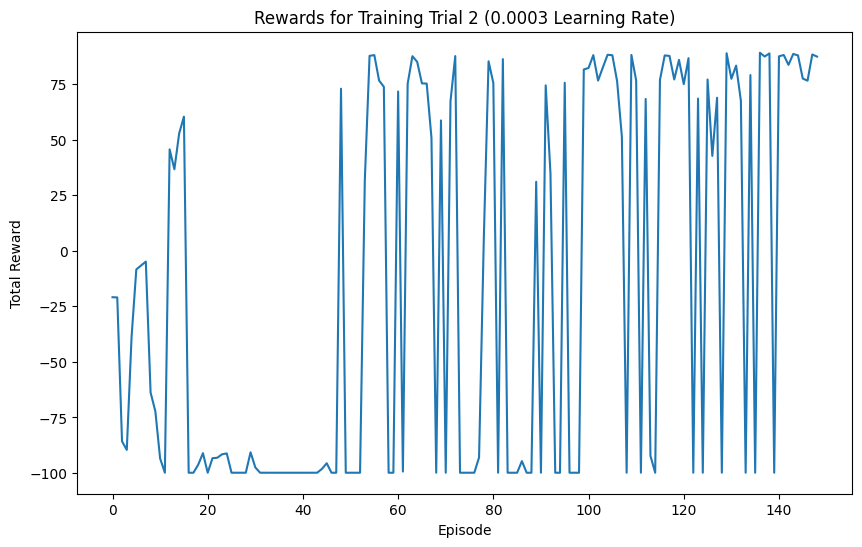

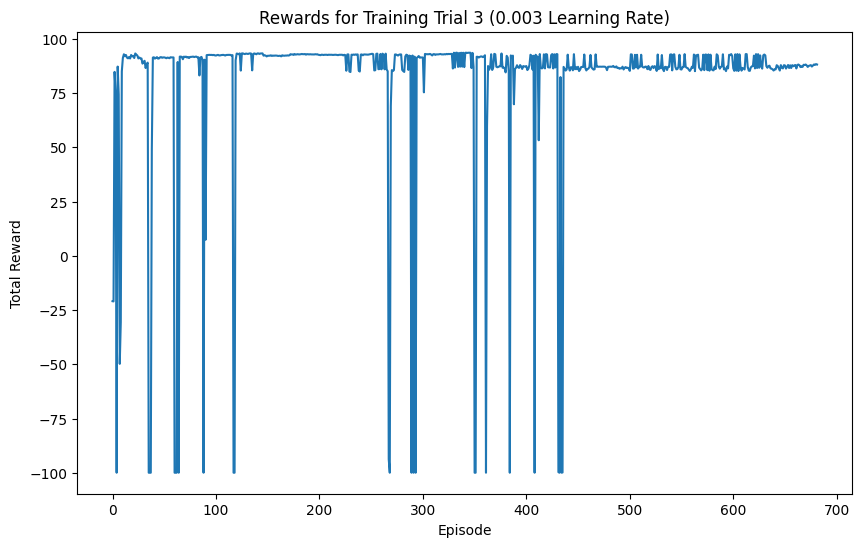

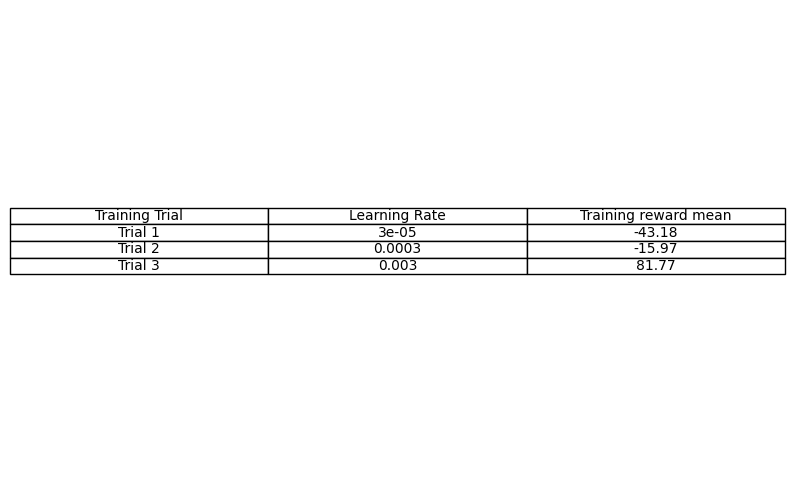

In [88]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({ln_rates[i]} Learning Rate)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", ln_rates[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Learning Rate", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
In this experiment we see that the small and default learning rates can't converge or even stabilise the algorithm to an optimal policy having a negative reward mean. The faster learning rate shows great results with an 81.77 reward mean and looks like the algorithm is converging in an optimal policy. Also, with bigger learning rates, the optimiser makes larger parameter updates, making the agent learn the optimal policy faster, terminating each episode sooner. This explains the different values of total episodes with each training trial.

### Maximum Gradient Clipping Analysis

During training, gradients are computed for each parameter in the networks, and if their total norm exceeds the threshold (max_grad_norm), they are scaled down proportionally to match the threshold. This prevents large updates, stabilizing training and avoiding exploding gradients. A smaller Maximum Gradient Clipping restricts updates more aggressively, improving stability but slowing convergence, while a larger one allows faster convergence but risks instability if the gradients become too large.

The gradients for all parameters

- $
g = [g_1, g_2, \dots, g_n]
$


The norm of the gradients is calculated as:

- $
\|g\|_2 = \sqrt{\sum_{i=1}^n g_i^2}
$


If
- $
\|g\|_2 > \text{max_grad_norm}
$

the gradients are scaled as:

- $
g_i' = g_i \cdot \frac{\text{max_grad_norm}}{\|g\|_2}
$

This ensures the new gradient norm satisfies:

- $
\|g'\|_2 = \text{max_grad_norm}
$

In [89]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
max_grad_norms = [0.4, 0.5, 0.6, 0.65, 0.7]
all_rewards = []
trial_rew_mean = []


for max_grad_norm in max_grad_norms:

  # Training trial with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {max_grad_norm} Maximum Gradient Clipping")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=ln_rate,                                          # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=0.01,                                                  # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=max_grad_norm,                                    # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=42,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this trial
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with 0.4 Maximum Gradient Clipping
All episodes: 441

Training with 0.5 Maximum Gradient Clipping
All episodes: 682

Training with 0.6 Maximum Gradient Clipping
All episodes: 625

Training with 0.65 Maximum Gradient Clipping
All episodes: 1099

Training with 0.7 Maximum Gradient Clipping
All episodes: 242
Model PPO_MLP saved successfully.


<Figure size 1000x600 with 0 Axes>

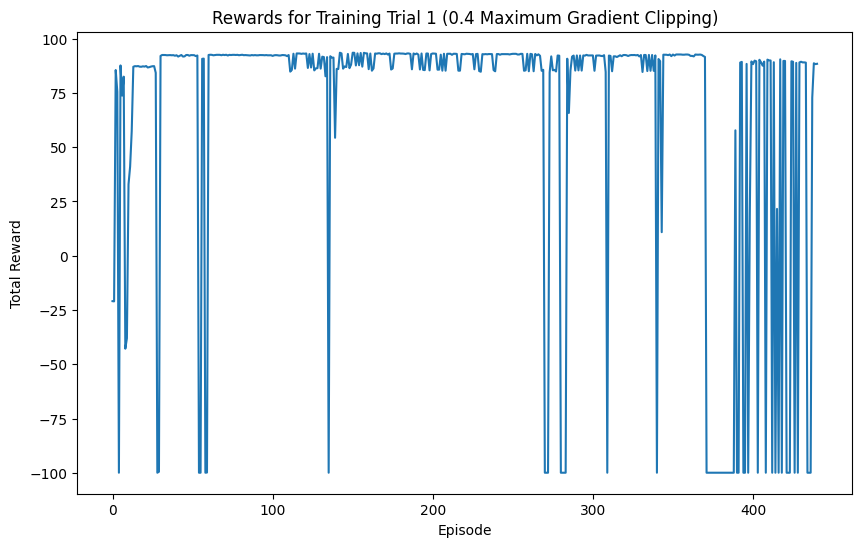

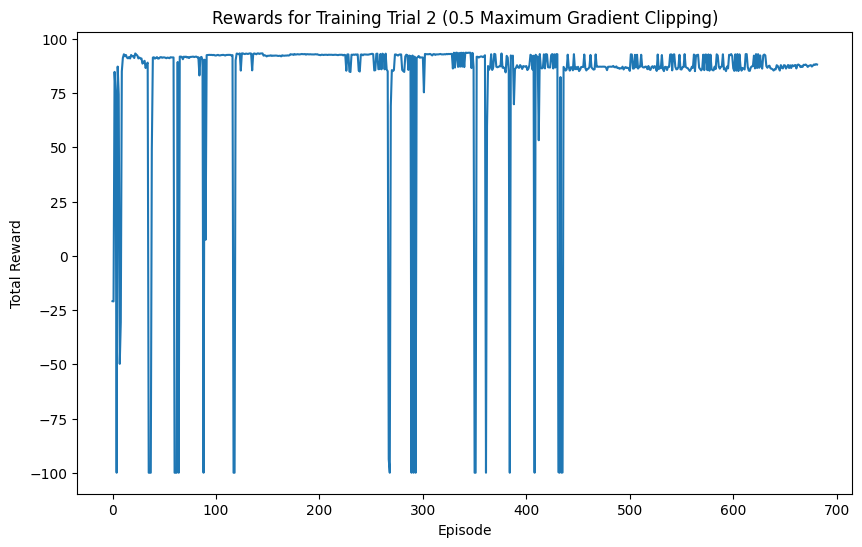

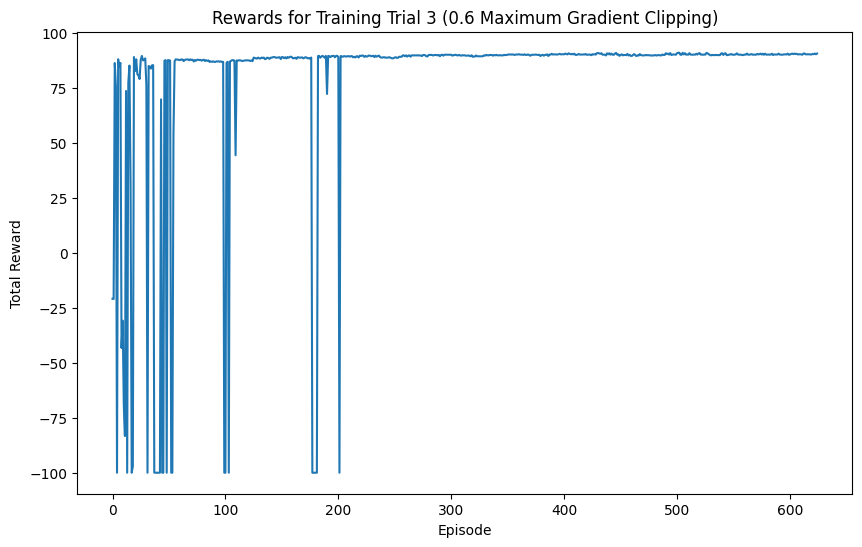

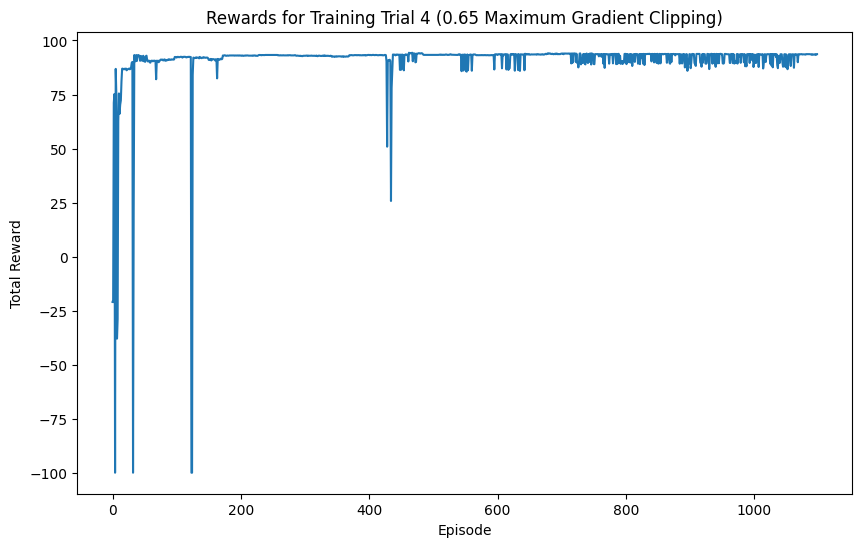

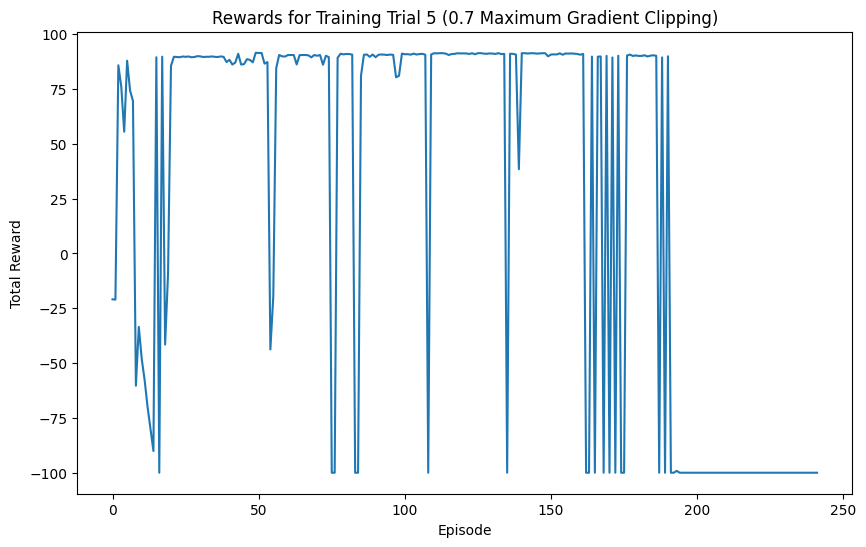

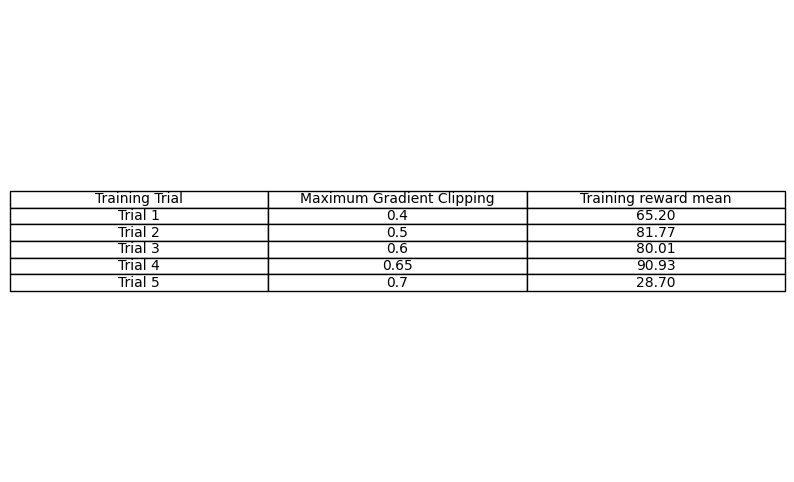

In [90]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({max_grad_norms[i]} Maximum Gradient Clipping)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", max_grad_norms[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Maximum Gradient Clipping", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
The graphs show that small gradient clipping values are unstable and the algorithm can't converge. The mid values around the default (0.5) are more stable and converge around an 80 training reward mean. The gradient clipping with higher values fluctuates more and is not so stable, but the algorithm converges faster, so it accumulates more positive rewards close to the 90 training reward mean. Bigger values than 0.65 destabilise the algorithm, making it fluctuate too much and preventing it from converging.

### Conclusion

In MountainCar continuous you only get a positive reward when you reach the top, with the PPO algorithm, that means that we will have a sparse reward problem. **PPO is an on-policy algorithm**, it performs a policy gradient update after each episode. Reaching the goal in MountainCar by random actions is a pretty rare event. When it finally happens, it's very unlikely that a single policy gradient update will be enough to start reaching the goal consistently, so PPO gets stuck again with no learning signal until it reaches the goal again by chance.

To counter that, I changed the hyperparameters for a more aggressive exploration and faster learning. A higher entropy coefficient **(ent_coef=0.01)** for more stochastic policies and wider exploration, while state-dependent exploration **(use_sde=True)** adapts exploration noise to different states. Also a higher **learning rate (3e−3)** and larger gradient updates **(max_grad_norm=0.6)**, allowing quicker adaptation to sparse rewards. This increases variance and training fluctuations, enabling the agent to explore more effectively and reduce the problem of the sparse reward signal, making the algorithm converge.

## PPO Optimal Model

I will use the hyperparameters tuned based on the above experiments. For the rest of the hyperparameters, I will use the default values:

- Discount factor $
\gamma = 0.99
$

- Clipping parameter $
\epsilon = 0.2
$

- Value function coefficient $
c_1 = 0.5
$

- GAE parameter $
\lambda = 0.95
$

In [91]:
# Create the callback
logger_callback = EpisodeLoggerCallback()
trial_rew_mean = []

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")

model = PPO(
    "MlpPolicy",
    env,
    learning_rate=3e-3,                                             # Change the learning rate
    n_steps=2048,                                                   # Steps per rollout
    batch_size=64,                                                  # Minibatch size
    n_epochs=10,                                                    # Optimization epochs per update
    gamma=0.99,                                                     # Discount factor
    clip_range=0.2,                                                 # Clipping range
    ent_coef=0.01,                                                  # Entropy coefficient
    vf_coef=0.5,                                                    # Value function coefficient
    max_grad_norm=0.6,                                              # Gradient clipping
    gae_lambda=0.95,                                                # GAE lambda
    use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
    seed=42,                                                        # Seeding
    verbose=0,                                                      # Verbosity level
    device='cpu'                                                    # Device
)

# Train the model with the callback
model.learn(total_timesteps=100_000, callback=logger_callback)
rewards = logger_callback.episode_rewards

# Compute the ep_rew_mean
ep_rew_mean = np.mean(logger_callback.episode_rewards)
trial_rew_mean.append(ep_rew_mean)

print("All episodes :", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")

All episodes : 625
Model PPO_MLP saved successfully.


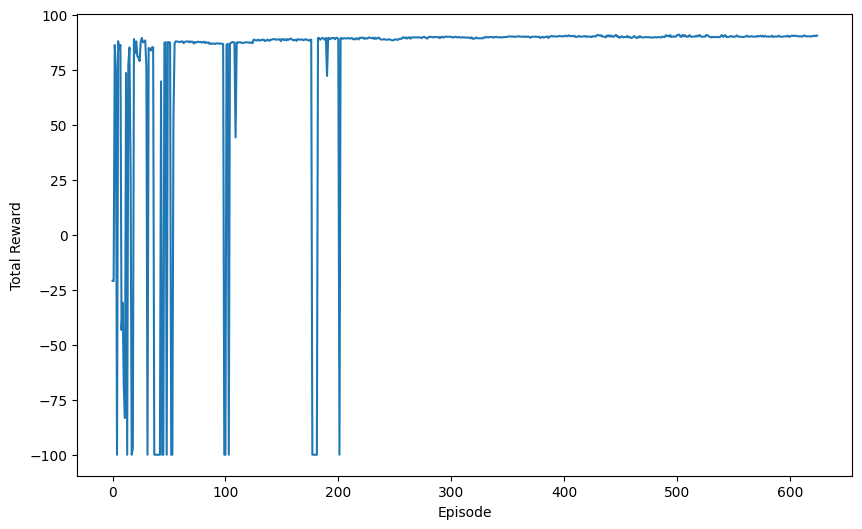

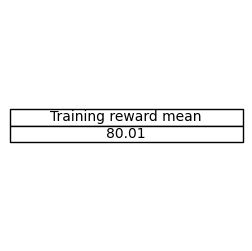

In [92]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

plt.figure(figsize=(3, 3))
plt.axis('off')
plt.table(
    cellText=[[f"{ep_rew_mean:.2f}"]],
    colLabels=["Training reward mean"],loc='center',cellLoc='center'
)
plt.show()


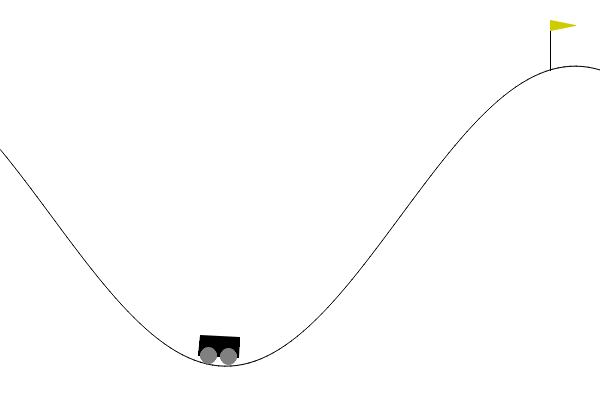

In [93]:
# Load the trained model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
model = PPO.load("PPO_MLP")
frames = []

# Test the model and save frames
obs, info = env.reset()
terminated, truncated = False, False

while not (terminated or truncated):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    frame = env.render()
    frames.append(frame)

env.close()

# Save the frames as a GIF
gif_filename = "mountain_car_simulation.gif"
imageio.mimsave(gif_filename, frames, fps=30, loop=0)

# Display the GIF
with open(gif_filename, 'rb') as f:
    data = f.read()
    b64_data = base64.b64encode(data).decode('utf-8')
    display(HTML(f'<img src="data:image/gif;base64,{b64_data}" width="600">'))


# A2C Algorithm